In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
def plot_graph(arr, ylabel='L2 hitrate', xlabel='kernels (in-order)'):
    fig = plt.figure(figsize=(20,8))
    ax = fig.add_subplot(111)
    plt.tight_layout()
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    ax.plot(arr)

In [4]:
def plot_bar(arr, ylabel='L2 hit-rate', xlabel='kernels (in-order)'):
    fig = plt.figure(figsize=(20,8))
    ax = fig.add_subplot(111)
    plt.tight_layout()
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    ax.bar(list(range(len(arr))), height=arr, width=1)

In [5]:
#model = 'resnet50'
#model = 'resnet152'
model = 'vgg16'

In [ ]:
onegpu = pd.read_csv('./src/'+model+'/nvprof_onegpu_entire.csv')
onegpu = onegpu.drop(0)


In [ ]:
def get_utils(df):
    utils = []
    df_utils = df['l2_utilization']
    for i in range(1,len(df_utils)+1):
        s = df_utils[i]
        u = ''.join((filter(str.isdigit, s)))
        utils.append(float(u))
    utils = np.array(utils)
    return utils

In [ ]:
utils1 = get_utils(onegpu)

In [ ]:
cols = onegpu.columns[4:]
onegpu[cols] = onegpu[cols].apply(pd.to_numeric, errors='coerce')

In [ ]:
multigpu = pd.read_csv('./src/'+model+'/multigpu.csv')
multigpu = multigpu.drop(0)
cols = multigpu.columns[4:]
multigpu[cols] = multigpu[cols].apply(pd.to_numeric, errors='coerce')

In [6]:
multigpu_nooverlap = pd.read_csv('./src/'+model+'/nvprof_multigpu_nooverlap_entire.csv')
multigpu_nooverlap = multigpu_nooverlap.drop(0)
cols = multigpu_nooverlap.columns[4:]
multigpu_nooverlap[cols] = multigpu_nooverlap[cols].apply(pd.to_numeric, errors='coerce')

In [ ]:
trans1 = onegpu['l2_tex_read_transactions'].to_numpy()
hitrate1 = onegpu['l2_tex_read_hit_rate'].to_numpy()

In [ ]:
trans4 = multigpu['l2_tex_read_transactions'].to_numpy()
hitrate4 = multigpu['l2_tex_read_hit_rate'].to_numpy()

In [7]:
trans4_nooverlap = multigpu_nooverlap['l2_tex_read_transactions'].to_numpy()
hitrate4_nooverlap = multigpu_nooverlap['l2_tex_read_hit_rate'].to_numpy()

In [ ]:
idx1 = trans1!=0
hitrate1 = hitrate1[idx1]
trans1 = trans1[idx1]

In [ ]:
idx4 = trans4!=0
hitrate4 = hitrate4[idx4]
trans4 = trans4[idx4]

In [ ]:
idx4_nooverlap = trans4_nooverlap!=0
hitrate4_nooverlap = hitrate4_nooverlap[idx4_nooverlap]
trans4_nooverlap = trans4_nooverlap[idx4_nooverlap]

## Printing L2 hit-rates

#### SingleGPU system, L2 hit-rate for GPU0

In [ ]:
plot_bar(hitrate1)

In [ ]:
print("Single GPU system, GPU0 average L2 hit-rate is {:2f}%".format(hitrate1.mean()))

#### Overlapped MultiGPU system, L2 hit-rate for GPU0

In [ ]:
plot_bar(hitrate4)

In [ ]:
print("4 GPU system, GPU0 average L2 hitrate is {:2f}%".format(hitrate4.mean()))

## Printing transactions

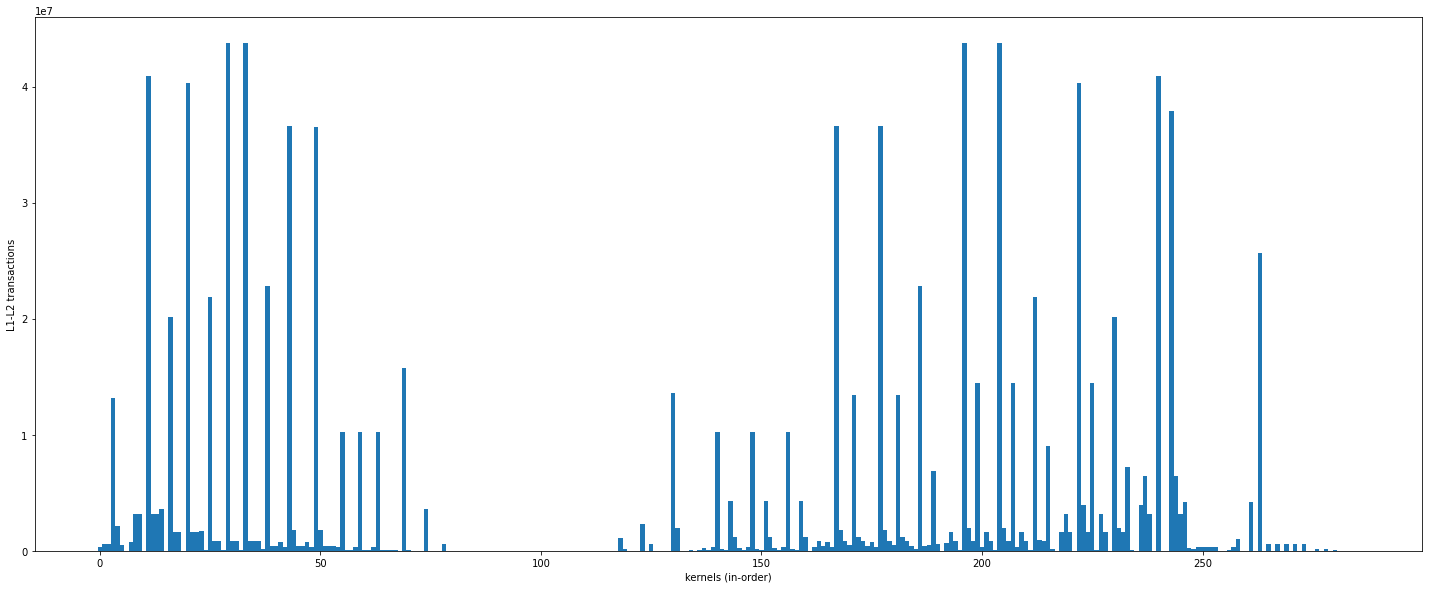

In [8]:
plot_bar(trans4_nooverlap, 'L1-L2 transactions')